## Analyzing outputs of 100 parameter sets ensemble simulaitons

Analyzing the first batch of ensemble simulations. <br/>
Simulation outputs stored: /home/disk/eos8/ach315/upscale/sims/opt

In [323]:
import os
import numpy as np
import pandas as pd
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import xarray as xr
import datetime
import seaborn as sns

### 1. Loading in parameter information

In [3]:
params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
params.head()

,staygreen,rmax_lir,rmax_ltar,juv_leaves,leaf_wid,WLRATIO,A_LW,LAF,f,scatt,vcm_25,vpm_25,g0,g1,t_opt,psi_threshold
0,4.192327,0.170936,1.116221,19,0.060117,1.578166,0.578437,1.082704,0.374039,0.799075,41.453395,63.020343,0.050014,4.262101,23.156285,-3.209627
1,5.085099,0.458642,0.532489,13,0.053712,1.593230,0.944650,2.500608,0.084047,0.638286,55.254491,76.360963,0.045041,9.476365,21.452484,-4.528151
2,5.462802,0.409265,1.126607,19,0.055231,1.452949,0.615309,1.305084,0.209307,0.547004,40.314858,68.638982,0.071773,3.290494,25.081642,-1.387541
3,2.468920,0.159873,0.209975,14,0.021548,1.951003,0.603160,1.430029,0.198690,0.216546,53.057031,71.797256,0.102321,3.169339,26.865773,-3.101738
4,2.217561,0.478633,0.463970,16,0.045654,1.027741,0.790700,1.147568,0.793187,0.582211,50.710891,78.179130,0.099021,6.539257,27.086055,-1.328671


### 2. Setting up xarray infrastructure to hold data

In [6]:
df_siteinfo = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/site_info.csv", index_col=0, dtype=str)
df_siteinfo.head()

,site,city,state,lat,lon
0,03103,FLAGSTAFF,AZ,35.08,111.4
1,03812,ASHEVILLE,NC,35.26,82.32
2,03813,MACON,GA,32.42,83.39
3,03820,AUGUSTA,GA,33.22,81.58
4,03822,SAVANNAH,GA,32.08,81.12


In [11]:
sites = df_siteinfo.site
lat = df_siteinfo.lat
lon = df_siteinfo.lon
years = np.arange(1961,1991)
cultivars = np.arange(1,101)

In [ ]:
ds = xr.Dataset()

### 3. Reading in simulation outputs

Thoughts: <br/>
Maybe I can create several pandas files that have sites as columns and time as rows. <br/>
I'll create 100 of these for all the cultivars. <br/>
I'll then use 'numpy.dstack' to stack all these 2d dataframes into a 3d matrix. <br/>
I'll then use this 3d matrix as the data input for xarray.

In [53]:
def get_filelist(path):
    '''
    For the given path, get the List of all files in the directory tree
    including those in subdirectories
    '''
    # create a list of file and sub directories names in the given directory 
    filelist = os.scandir(path)
    allfiles = list()
    # iterate over all the entries
    for entry in filelist:
        # create full path
        fullpath = os.path.join(path, entry)
        # if entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullpath):
            allfiles = allfiles + get_filelist(fullpath)
        else:
            allfiles.append(fullpath)
    return allfiles

In [62]:
%%time
filelist = get_filelist('/home/disk/eos8/ach315/upscale/sims/opt/')

CPU times: user 4.35 s, sys: 9.43 s, total: 13.8 s
Wall time: 25.5 s


In [63]:
len(filelist)

212132

In [56]:
f = open('/home/disk/eos8/ach315/upscale/sims/opt/1961/var_0/out1_03813_1961_var_0.txt')
flines = f.readlines()
print(flines[-1])

08/08/1961, 22501,       5,   19.91,      19,      12,  1781.77,  2862.58,    1.78,   93.31, -1.5000,    0.00,    0.00,   22.46,   21.10,    -nan,      -nan,     0.110, -0.0316,  0.0000,  0.0378,  0.0000,       0.000,       1.782,        0.00,        0.00,     -1.6427,     -1.6427,      0.0000,      0.0000,        -nan,        -nan,    0.167,    0.4418,    0.8909,    1.2202,    0.0486,    0.0000,  51.112,   7.005,    0.00,    4.87,    4.48,    2.14,  44.106,  44.214,     0.0,       0.000,    0.04,           "Matured"



In [57]:
test = pd.read_csv('/home/disk/eos8/ach315/upscale/sims/opt/1961/var_0/out1_03813_1961_var_0.txt')

In [178]:
test = [value.strip() for value in flines[-1].split(',')]

In [64]:
# manual update of maizsim output column name
cols = ['jday', 'time', 'leaves', 'mature_lvs', 'drop_lvs', 'LA', 'LA_dead', 'LAI', 'RH', 
        'leaf_WP', 'PFD', 'solrad', 'temp_soil', 'temp_air', 'temp_can', 'ET_dmd', 'ET_suply',
        'Pn', 'Pg', 'resp', 'av_gs', 'LAI_sunlit', 'LAI_shaded', 'PFD_sunlit', 'PFD_shaded', 
        'An_sunlit', 'An_shaded', 'Ag_sunlit', 'Ag_shaded', 'gs_sunlit', 'gs_shaded', 'VPD',
        'N', 'N_dmd', 'N_upt', 'N_leaf', 'PCRL', 'dm_total', 'dm_shoot', 'dm_ear', 'dm_totleaf', 'dm_dropleaf', 
        'df_stem', 'df_root', 'roil_rt', 'mx_rootdept', 'available_water', 'soluble_c', 'note']

In [ ]:
%%time

years = []
cvars = []
sites = []
biomass = []
ears = []
devstage = []

files = filelist[:]

for file in files:
    # extrating basic file info
    year = file.split('/')[-3]
    site = file.split('/')[-1].split('_')[1]
    var = file.split('/')[-1].split('_')[-1].split('.')[0]
    
    # reading in file and setting up structure
    with open(file, 'r') as f:
        f.seek(0, os.SEEK_END)
        f.seek(f.tell() - 3000, os.SEEK_SET) # reading in the last few lines
        for line in f:
            f_content = f.readlines()

    
    stage = f_content[-1].split(',')[-1].strip() # selecting last line - end point of simulation
    ear = float(f_content[-1].split(',')[-10]) # ear
    mass = float(f_content[-1].split(',')[-12]) # total biomass
        
    # compiling info
    years.append(year)
    cvars.append(var)
    sites.append(site)
    biomass.append(mass)
    ears.append(ear)
    devstage.append(stage)


In [127]:
with open('/home/disk/eos8/ach315/upscale/sims/opt/1985/var_9/out1_03822_1985_var_9.txt', 'r') as f:
    f_contents = f.readlines()
f_contents[0]

'date,    jday, time,   Leaves, MaturLvs,  Dropped,LA/pl,   LA_dead, LAI,    RH,     LeafWP, PFD,    SolRad, SoilT,  Tair,   Tcan,   ETdmd,     ETsply,    Pn,  Pg,     Respir,   av_gs,  sunlit_LAI, shaded_LAI, sunlit_PFD, shaded_PFD, sunlit_An,  shaded_An,  sunlit_Ag,  shaded_Ag,  sunlit_gs,  shaded_gs   VPD,     Nitr,     N_Dem,    NUpt,     LeafN,    PCRL,     totalDM,shootDM,earDM,  TotleafDM,DrpLfDM,  stemDM, rootDM, SoilRt, MxRtDep,AvailW, solubleC,Note     \n'

In [235]:
test = pd.read_csv('/home/disk/eos8/ach315/upscale/sims/opt/1965/var_90/out1_13722_1965_var_90.txt')
test.columns = cols
test.head()

,jday,time,leaves,mature_lvs,drop_lvs,LA,LA_dead,LAI,RH,leaf_WP,...,dm_ear,dm_totleaf,dm_dropleaf,df_stem,df_root,roil_rt,mx_rootdept,available_water,soluble_c,note
04/01/1965,23833,0,0.0,0,0,0.0,0.0,0.0,88.36,-0.05,...,0.0,0.15,0.0,0.02,0.11,0.0,0.0,0.0,0.0,"""none"""
04/01/1965,23833,1,0.0,0,0,0.0,0.0,0.0,92.29,-0.05,...,0.0,0.15,0.0,0.02,0.11,0.0,0.0,0.0,0.0,"""none"""
04/01/1965,23833,2,0.0,0,0,0.0,0.0,0.0,92.29,-0.05,...,0.0,0.15,0.0,0.02,0.11,0.0,0.0,0.0,0.0,"""none"""
04/01/1965,23833,3,0.0,0,0,0.0,0.0,0.0,92.29,-0.05,...,0.0,0.15,0.0,0.02,0.11,0.0,0.0,0.0,0.0,"""none"""
04/01/1965,23833,4,0.0,0,0,0.0,0.0,0.0,88.36,-0.05,...,0.0,0.15,0.0,0.02,0.11,0.0,0.0,0.0,0.0,"""none"""


In [67]:
sims_61_85 = pd.DataFrame({'year': years,
                           'cultivar': cvars,
                           'site': sites,
                           'ear': ears})
sims_61_85.to_csv('/home/disk/eos8/ach315/upscale/test/sims_6185.txt')

In [146]:
test = pd.read_csv('/home/disk/eos8/ach315/upscale/test/sims_6185.txt')

In [147]:
test.head()

,Unnamed: 0,year,cultivar,site,ear
0,0,1961,0,3813,0.0
1,1,1961,0,3820,0.0
2,2,1961,0,3822,0.0
3,3,1961,0,3856,0.0
4,4,1961,0,3928,0.0


In [365]:
# in order to read in file as text file, must use a bit more lines of code
file_to_read = '/home/disk/eos8/ach315/upscale/sims/opt/1965/var_90/out1_13722_1965_var_90.txt'
with open(file_to_read, 'r') as f:
    f.seek(0, os.SEEK_END)
    f.seek(f.tell() - 3000, os.SEEK_SET) # reading in the last few lines
    for line in f:
        f_content = f.readlines()

sim_end = f_content[-1] # selecting last line - end point of simulation

In [378]:
print(float(sim_end.split(',')[-10])) # ear
print(float(sim_end.split(',')[-12])) # total biomass
print(sim_end.split(',')[-1].strip()) # total biomass

15.28
197.197
"Matured"


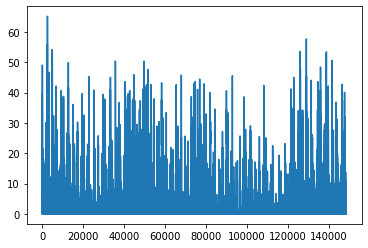

In [121]:
plt.plot(test.ear)